In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
# STEP 1: READ AND PREPARE THE DATA
def load_and_clean_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    # Set Date as the index for time series analysis
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    return df
df = load_and_clean_data('P639 DATASET.csv')

In [61]:
df. info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2011 non-null   float64
 1   High       2011 non-null   float64
 2   Low        2011 non-null   float64
 3   Close      2011 non-null   float64
 4   Adj Close  2011 non-null   float64
 5   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.0 KB


In [62]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [63]:
df. describe()

,Open,High,Low,Close,Adj Close,Volume
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,126.707469,127.827594,125.580258,126.741235,119.505548,5.949670e+07
std,50.483753,50.926301,50.124940,50.578369,52.438444,4.683856e+07
min,55.424286,57.085712,55.014286,55.790001,48.921928,1.136200e+07
25%,85.882858,86.717858,85.056427,86.202145,75.056679,2.758565e+07
50%,113.050003,114.190002,111.870003,113.050003,105.222908,4.346900e+07
75%,165.190002,167.409996,163.424995,165.245002,160.047111,7.471030e+07
max,291.119995,293.970001,288.119995,291.519989,289.522614,3.765300e+08


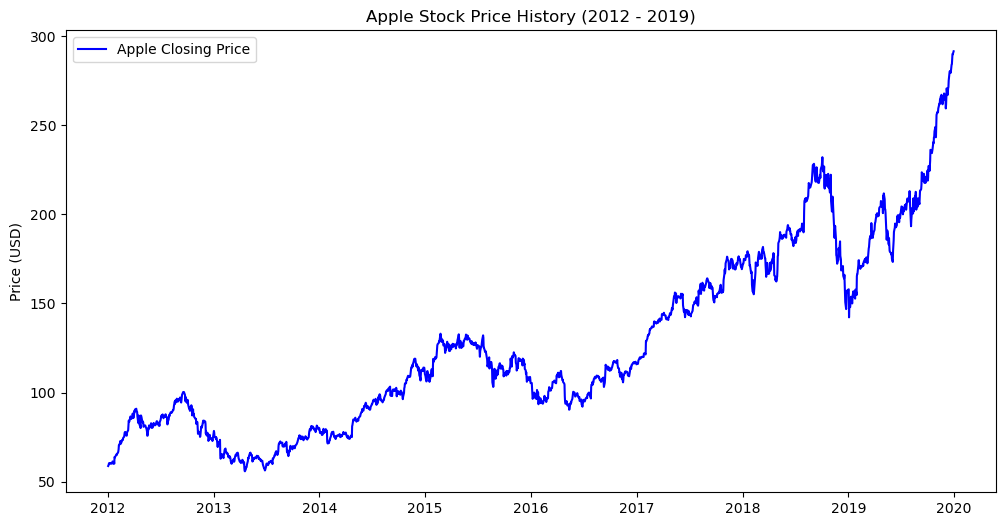

In [64]:
#STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# Plotting the historical trend
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Apple Closing Price', color='blue')
plt.title('Apple Stock Price History (2012 - 2019)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

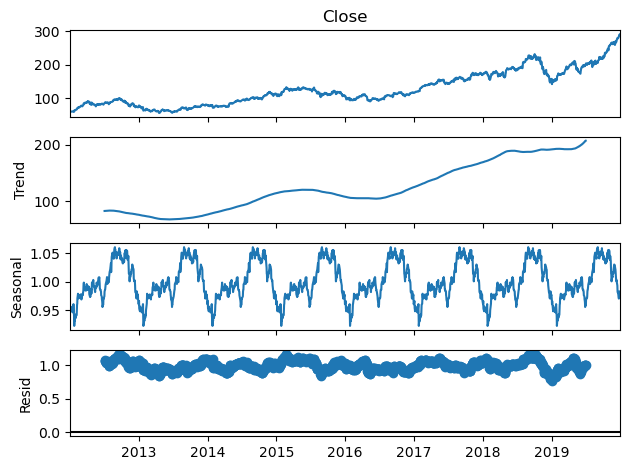

In [65]:
# Decomposing the series to see Trend and Seasonality
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=252)
decomposition.plot()
plt.show()

In [122]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [123]:
# 1. Check for Stationarity (ADF Test)
# If p-value > 0.05, the data is NOT stationary and needs 'differencing' (d)
print("--- Augmented Dickey-Fuller Test ---")
adf_result = adfuller(df['Close'].dropna())
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')

--- Augmented Dickey-Fuller Test ---
ADF Statistic: 1.2194
p-value: 0.9961


In [124]:
# 2. Differencing to make data stationary
# This is why we use '1' in the middle of ARIMA(5, 1, 0)
df['Close_diff'] = df['Close'].diff()

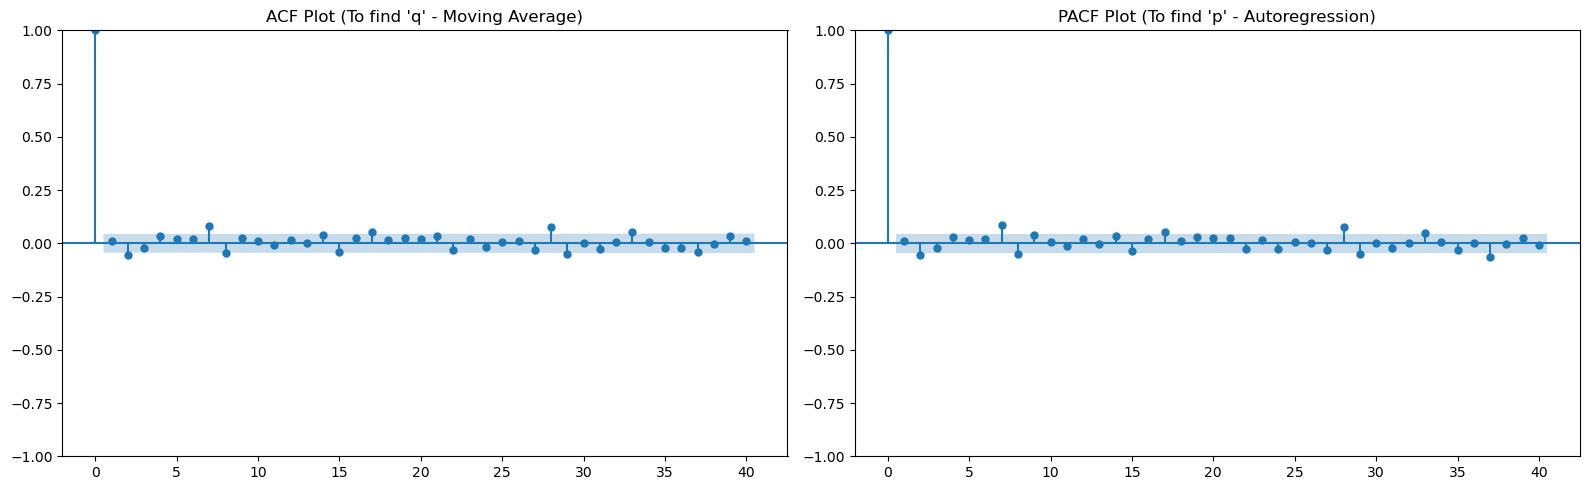

In [125]:
# 3. Plot ACF and PACF
# These plots help determine 'p' and 'q' values for ARIMA
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df['Close_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF Plot (To find 'q' - Moving Average)")

plot_pacf(df['Close_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF Plot (To find 'p' - Autoregression)")

plt.tight_layout()
plt.show()

In [101]:
# STEP 3: FEATURE ENGINEERING (For XGBoost)
def create_ml_features(data):
    df_feat = data.copy()
    
    # Date Features
    df_feat['DayOfWeek'] = df_feat.index.dayofweek
    df_feat['Month'] = df_feat.index.month
    df_feat['Year'] = df_feat.index.year
    
    # Lag & Trend Features
    for i in range(1, 8):
        df_feat[f'Lag_{i}'] = df_feat['Close'].shift(i)
    df_feat['MA7'] = df_feat['Close'].rolling(window=7).mean()
    df_feat['MA30'] = df_feat['Close'].rolling(window=30).mean()
    
    # IMPORTANT: We only keep columns we can calculate for the future.
    # We drop Open, High, Low, Volume, and Adj Close.
    keep_cols = ['Close', 'DayOfWeek', 'Month', 'Year', 'MA7', 'MA30'] + [f'Lag_{i}' for i in range(1, 8)]
    return df_feat[keep_cols].dropna()

# Prepare full feature set
ml_data = create_ml_features(df)

In [102]:
# STEP 4: MODEL BUILDING & EVALUATION
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor  # Note: Ensure xgboost is installed
from sklearn.metrics import mean_squared_error

In [103]:
# Splitting data (last 30 days for testing)
train_df = ml_data.iloc[:-30]
test_actuals = ml_data.iloc[-30:]['Close']

In [104]:
# 1. ARIMA MODEL & FORECAST
# We train on the full 'Close' price history
arima_test_model = ARIMA(train_data['Close'], order=(2, 1, 2)).fit()
arima_test_preds = arima_test_model.forecast(steps=30)

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

In [105]:
arima_mse = mean_squared_error(test_data['Close'], arima_test_preds)
print(f"ARIMA Mean Squared Error: {arima_mse:.4f}")

ARIMA Mean Squared Error: 176.6218


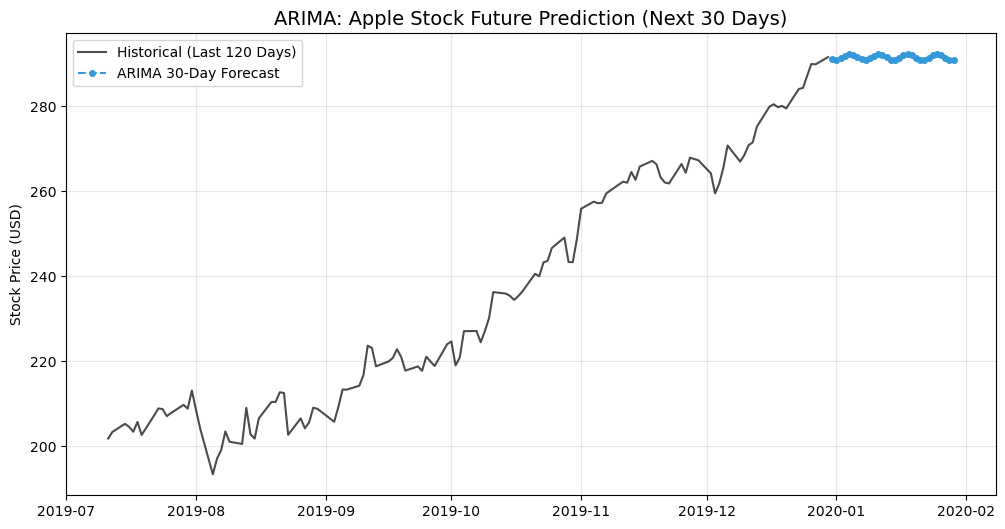

In [106]:
plt.figure(figsize=(12, 6))
plt.plot(history_subset.index, history_subset['Close'], label='Historical (Last 120 Days)', color='black', alpha=0.7)
plt.plot(future_dates, arima_preds, label='ARIMA 30-Day Forecast', color='#3498db', linestyle='--', marker='o', markersize=4)
plt.title('ARIMA: Apple Stock Future Prediction (Next 30 Days)', fontsize=14)
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [107]:
# 2. SARIMAX MODEL & FORECAST
# Seasonal order (1,1,1,5) assumes a 5-day trading week pattern
sarimax_test_model = SARIMAX(train_data['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 5)).fit(disp=False)
sarimax_test_preds = sarimax_test_model.forecast(steps=30)

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

In [108]:
sarimax_mse = mean_squared_error(test_data['Close'], sarimax_test_preds)
print(f"SARIMAX Mean Squared Error: {sarimax_mse:.4f}")

SARIMAX Mean Squared Error: 134.8301


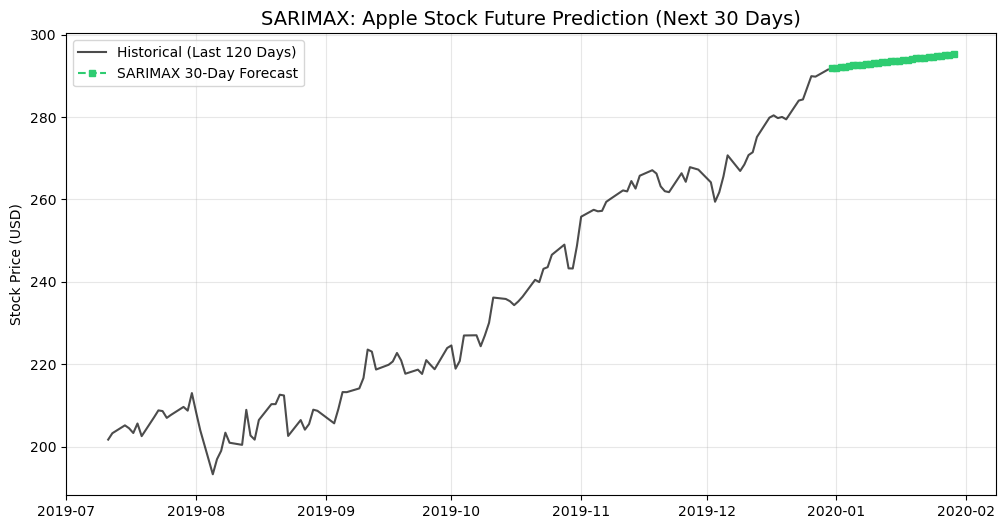

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(history_subset.index, history_subset['Close'], label='Historical (Last 120 Days)', color='black', alpha=0.7)
plt.plot(future_dates, sarimax_preds, label='SARIMAX 30-Day Forecast', color='#2ecc71', linestyle='--', marker='s', markersize=4)
plt.title('SARIMAX: Apple Stock Future Prediction (Next 30 Days)', fontsize=14)
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [110]:
# 3. XGBoost Model
X_train_eval = train_df.drop(columns=['Close'])
y_train_eval = train_df['Close']

In [111]:
# Now the model only expects the features we can actually provide in the loop!
eval_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
eval_model.fit(X_train_eval, y_train_eval)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [112]:
# Recursive forecast on the test period (to get MSE)
working_df_eval = df.iloc[:-30][['Close']].copy()
eval_preds = []

In [113]:
for day in df.index[-30:]:
    features = {
        'DayOfWeek': day.dayofweek, 'Month': day.month, 'Year': day.year,
        'MA7': working_df_eval['Close'].iloc[-7:].mean(),
        'MA30': working_df_eval['Close'].iloc[-30:].mean()
    }
    for i in range(1, 8):
        features[f'Lag_{i}'] = working_df_eval['Close'].iloc[-i]
    
    input_row = pd.DataFrame([features])[X_train_eval.columns]
    pred = eval_model.predict(input_row)[0]
    eval_preds.append(pred)
    working_df_eval = pd.concat([working_df_eval, pd.DataFrame({'Close': [pred]}, index=[day])])

In [114]:
xgb_mse = mean_squared_error(test_actuals, eval_preds)
print(f"XGBoost Mean Squared Error (MSE): {xgb_mse:.4f}")

XGBoost Mean Squared Error (MSE): 156.6328


In [115]:
# PART 2: FUTURE PREDICTION (NEXT 30 DAYS)
# ==========================================
# Train on FULL data for the actual future forecast
X_full = ml_data.drop(columns=['Close'])
y_full = ml_data['Close']
model_full = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
model_full.fit(X_full, y_full)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [116]:
working_df = df[['Close']].copy()
future_preds = []
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

In [117]:
for day in future_dates:
    features = {
        'DayOfWeek': day.dayofweek, 'Month': day.month, 'Year': day.year,
        'MA7': working_df['Close'].iloc[-7:].mean(),
        'MA30': working_df['Close'].iloc[-30:].mean()
    }
    for i in range(1, 8):
        features[f'Lag_{i}'] = working_df['Close'].iloc[-i]
    
    input_row = pd.DataFrame([features])[X_full.columns]
    pred = model_full.predict(input_row)[0]
    future_preds.append(pred)
    working_df = pd.concat([working_df, pd.DataFrame({'Close': [pred]}, index=[day])])

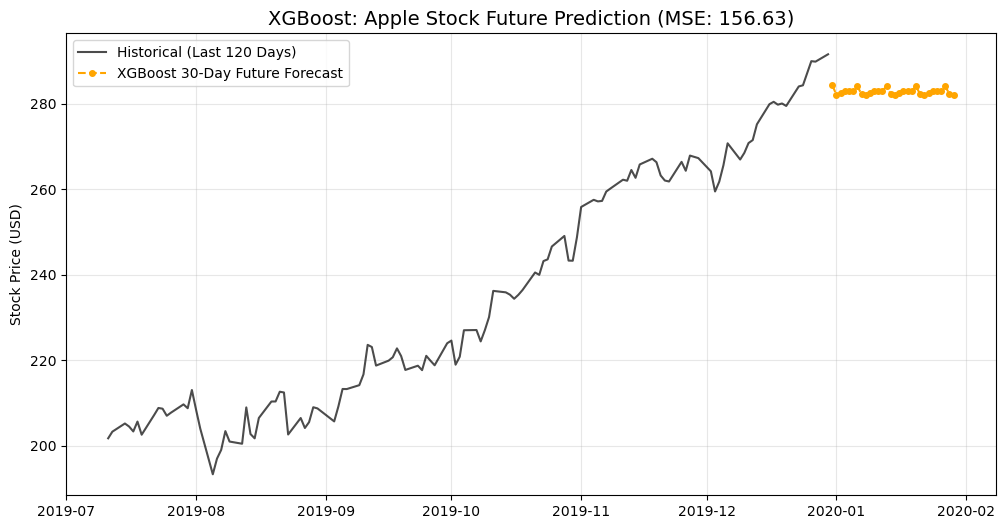

In [118]:
# PART 3: VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 6))
plt.plot(df.index[-120:], df['Close'].tail(120), label='Historical (Last 120 Days)', color='black', alpha=0.7)
plt.plot(future_dates, future_preds, label='XGBoost 30-Day Future Forecast', color='orange', linestyle='--', marker='o', markersize=4)
plt.title(f'XGBoost: Apple Stock Future Prediction (MSE: {xgb_mse:.2f})', fontsize=14)
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [119]:
mse_results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMAX', 'XGBoost'],
    'Mean Squared Error (MSE)': [arima_mse, sarimax_mse, xgb_mse]
})

In [120]:
# Sort by MSE (Lowest error at the top)
mse_results = mse_results.sort_values(by='Mean Squared Error (MSE)').reset_index(drop=True)

In [121]:
print("--- Model Performance Leaderboard ---")
print(mse_results)

--- Model Performance Leaderboard ---
     Model  Mean Squared Error (MSE)
0  SARIMAX                134.830096
1  XGBoost                156.632784
2    ARIMA                176.621815
